## Quality Control and Curation Notebook

Here, the models are loaded, configured, tested, and modified if needed. The models used are the following:
* *Lactobacillus brevis* ATCC367
* *Lactobacillus plantarum* JDM1
* *Lactobacilus plantarum* WCFS1
* *Pseudomonas aeruginosa* PAO1
* *Staphylococcus aureus* USA300

In [225]:
import cobra
from micom import Community

Below a dictionary of models is constructed to aid in loading each model. Every name is replaced with the respective COBRApy object of the model once it is loaded. This is particularly useful when working with community models.

In [226]:
# Load models iteratively
models_dictionary = {}
strains = ["Lactobacillus_brevis_ATCC_367", "Lactobacillus_plantarum_JDM1",
           "Lactobacillus_plantarum_WCFS1", "Pseudomonas_aeruginosa_NCGM2_S1","Pseudomonas_aeruginosa_PAO1",
           "Staphylococcus_aureus_subsp_aureus_USA300_FPR3757", "Bacteroides_fragilis_NCTC_9343"]
strains_short = ["l_brevis_atcc367", "l_plantarum_jdm1", "l_plantarum_wcfs1", "p_aeruginosa_ncgm2_s1", "p_aeruginosa_pao1", "s_aureus_usa300", "b_fragilis_nctc_9343"]
#shortened_names = [strain[0] + "_" + strain[strain.find("_") : strain.find("_") + 3] + strain.reverse().find()]
# Define PATH constant prefix
PATH = f"../model_data/"
for index, strain in enumerate(strains):
    models_dictionary[strains_short[index]] = PATH + strains[index] + ".xml"

### Quality Control with MEMOTE

MEMOTE is an open-source framework for testing and benchmarking metabolic models according to the standards in the field ([Lieven et al., 2020](https://doi.org/10.1038%2Fs41587-020-0446-y)). All of the models that are to be refined and used in the final implementation were first tested out with MEMOTE.

***Note***: All of the analyses were rerun with the models from the 2022 build (replacing those from the older 2012 build) on May 8th, 2025. Also, the runs were on a remote Linux device (GitHub Codespaces).

In [ ]:
import memote.suite
import memote.suite.cli
import memote.suite.cli.reports

# Performing single MEMOTE tests of the strains in use
models_list, qcTestResults = [], []
for strain in models_dictionary.keys():
    models_list.append(cobra.io.read_sbml_model(models_dictionary[strain]))
for model in models_list:
    qcTestResults.append(memote.suite.cli.reports.snapshot(model))
print('Finished MEMOTE tests!')

### Utility Functions

#### Filtering for Rate-determining Reactions

In [1]:
import pandas as pd
import cobra
import numpy as np

In [41]:
def sortEssentialReactions(essential_reactions, single_reaction_deletion, model : cobra.Model):
    single_reaction_deletion = single_reaction_deletion.copy()
    output = {'ids':[], 'growth':[], 'name':[], 'status':[]}
    for ind, rxn in enumerate(single_reaction_deletion['ids']):
        rxnID = rxn.pop()
        reaction = model.reactions.get_by_id(rxnID)
        if (reaction in essential_reactions):
            output['ids'].append(rxnID)
            output['growth'].append(single_reaction_deletion['growth'][ind])
            output['name'].append(reaction.name)
            output['status'].append(single_reaction_deletion['status'][ind])
    output = pd.DataFrame(output)
    output.sort_values(by='growth', axis=0, inplace=True)
    return output

In [42]:
def search_in_reaction_df(targets : list[str], sorted_essential_reactions : pd.DataFrame):
    output = []
    for ind, rxn in enumerate(sorted_essential_reactions['Name']):
        _included = False
        for target in targets:
            if (target in rxn) and _included == True:
                output.append(sorted_essential_reactions.iloc[ind])
                _included = True
            else:
                continue
        _included = False
    return output

In [43]:
def find_pivotal_reactions(model : cobra.Model, filter = 0.1, query : list[str] | None = None):
    # Identifying essential reactions for updating the kinetic and optimal pH data
    essential_reactions = cobra.flux_analysis.find_essential_reactions(model, 0.2)
    for rxn in essential_reactions:
        rxn = rxn.id
    # Assessing how each reaction deletion affects growth in P. aeruginosa strains PAO1 and NCGM2_S1
    single_reaction_deletion = cobra.flux_analysis.single_reaction_deletion(model, method='fba')
    # Sorting the essential reactions
    sorted_essential_reactions = sortEssentialReactions(essential_reactions, single_reaction_deletion, model)
    # Applying the filter to separate the most influential reactions
    if (filter <= 1):
        sorted_essential_reactions = sorted_essential_reactions.head(int(filter * len(sorted_essential_reactions))) # Filter by percentage
    else:
        sorted_essential_reactions = sorted_essential_reactions.head(int(filter)) # Filter by number
    if (query):
        sorted_essential_reactions = search_in_reaction_df(query, sorted_essential_reactions)
    return sorted_essential_reactions

#### Taxonomy Creator

Note that this function originally belongs to the `coculture_test_micom_small` notebook and is only included for the sake of benchmarking model curations.

In [44]:
# Defining a function for creating custom taxonomy files complete with the required file address
import pandas as pd
import numpy as np
import cobra

def create_tax_dataset(models : list[cobra.Model] | tuple[cobra.Model], paths : list | tuple, abundance : list | np.ndarray, include_sample_id = False, samples = 1) -> pd.DataFrame:
    # Defining the dataframe with the necessary columns
    output_dict = {'id':[], 'genus':[], 'species':[], 'reactions':[], 'metabolites':[], 'file':[], 'sample_id':[], 'abundance':[]}
    for i in range(samples):
        sample_id = i
        for j, model in enumerate(models):
            output_dict['id'].append(model.id + '_' + str(j))
            output_dict['genus'].append(model.name.split(' ')[0])
            output_dict['species'].append(model.name)
            output_dict['reactions'].append(len(model.reactions))
            output_dict['metabolites'].append(len(model.metabolites))
            output_dict['file'].append(paths[j])
            output_dict['sample_id'].append('sample_' + str(i + 1))
            if (samples > 1 and sample_id > 0):
                output_dict['abundance'].append(int(np.random.normal(loc=abundance[j])))
            else:
                output_dict['abundance'].append(abundance[j])
    output = pd.DataFrame(output_dict, columns=output_dict.keys())
    if not (include_sample_id):
        output.drop(columns=['sample_id'], axis=1, inplace=True)
    return output

#### Searching for Reactions and Metabolites

In [45]:
def find_rxn_met(model : cobra.Model, reaction : str | None = None, metabolite : str | None = None):
    if (reaction):
        for rxn in model.reactions:
            if reaction in rxn.name:
                print('Found!')
                print('Name:', rxn.name)
                print('ID:', rxn.id)
                print('Reaction formula:', rxn.reaction)
    if (metabolite):
        for met in model.metabolites:
            if metabolite in met.name:
                print('Found!')
                print('Name:', met.name)
                print('ID:', met.id)
                for rxn in met.reactions:
                    print('Related reaction:', rxn.id, rxn.name, rxn.reaction)

In [46]:
# Defining a utility function for retrieving the EC number for a given reaction
def report_ec_number(model : cobra.Model, reaction_id : str):
    for rxn in model.reactions:
        if reaction_id == rxn.id:
            if 'ec-code' in rxn.annotation.keys():
                return rxn.annotation['ec-code']
            else:
                return '0.0.0.0'

#### Thermodynamic Constraint Refinement
This section includes functions for interacting with the `equilibrator-api` module. This helps add more realism to the constraint applied to reactions throughout the models.

In [73]:
import cobra
from equilibrator_api import ComponentContribution
import sys

def update_thermodynamic_boundaries(model : cobra.Model, reaction_ids : list[str], heuristic = 40, scale_boundaries = False, first_few = None):

    # Initializing the ComponentContribution calculator
    cc = ComponentContribution()

    # Looping over each reaction in the list
    for rxn_id in reaction_ids[:first_few]:
        reaction = model.reactions.get_by_id(rxn_id)
        ec_number = report_ec_number(model, rxn_id)

        # Storing the string form of the reaction to use for eQuilibrator queries
        rxn_formula = reaction.reaction
        rxn_formula = rxn_formula.replace('[c]', '')
        rxn_formula = rxn_formula.replace('[p]', '')
        rxn_formula = rxn_formula.replace('[e]', '')
        rxn_formula = rxn_formula.replace('_m', '')
        if ('[' in rxn_formula or ']' in rxn_formula):
            print('Skipping reaction ...')
            continue

        # Computing the standard ΔG°′ (in kJ/mol) at pH 7.0 using ComponentContribution.
        # The function returns a DeltaG object with attributes 'dg' and 'uncertainty'.
        #delta_g_obj = cc.standard_dg_rxn(rxn_formula, pH=7.0) # NONFUNCTIONAL
        # Using the EC Number to get a DeltaG object
        try:
            rxn_search = cc.search_reaction(rxn_formula)
            delta_g_obj = cc.standard_dg_prime(rxn_search)
        except:
            print(f'Reaction {rxn_formula} could not be retrieved! Skipping ...')
            continue
        # Extracting reaction info
        delta_g = delta_g_obj.value.m_as('kJ/mol') # Corrected from the AI version
        uncertainty = delta_g_obj.error.m_as('kJ/mol') # Corrected from the AI version
        print(f"Reaction {rxn_id}: ΔG°′ = {delta_g:.2f} ± {uncertainty:.2f} kJ/mol")

        # Saving the original bounds for reference
        orig_upper = reaction.upper_bound
        orig_lower = reaction.lower_bound

        # Example heuristic for setting a new flux boundary:
        if delta_g > heuristic:
            # If the reaction is strongly unfavorable in the forward direction,
            # block forward flux by setting the upper bound to zero.
            reaction.upper_bound = 0
            print(f"Setting reaction {rxn_id} upper bound to 0 due to high ΔG (> +30 kJ/mol).")
        elif delta_g < -heuristic:
            # If the reaction is strongly favorable in the forward direction (i.e. very unfavorable in reverse),
            # block reverse flux by setting the lower bound to zero.
            reaction.lower_bound = 0
            print(f"Setting reaction {rxn_id} lower bound to 0 due to very negative ΔG (< -30 kJ/mol).")
        else:
            if (scale_boundaries):
                # For moderate ΔG values, you might want to scale the maximum flux linearly.
                # This is a rough heuristic: for example, we compute a scaling factor that decreases linearly
                # with the magnitude of ΔG. Here, we use:
                #     scaling_factor = max(0.1, 1 - abs(ΔG)/100)
                # Thus, if |ΔG| = 50 kJ/mol, scaling_factor will be 0.5; if |ΔG| = 100, then 0.1 (minimum).
                scaling_factor = max(0.1, 1 - abs(delta_g) / 100.0)
                reaction.upper_bound = orig_upper * scaling_factor
                reaction.lower_bound = orig_lower * scaling_factor
                print(f"Scaling {rxn_id} bounds by factor {scaling_factor:.2f} due to moderate ΔG.")
            else:
                print("No other boundaries scaled!")


In [78]:
# Loading models to benchmark constraint refinement
l_brevis_atcc367 = cobra.io.read_sbml_model(models_dictionary['l_brevis_atcc367'])
p_aeruginosa_pao1 = cobra.io.read_sbml_model(models_dictionary['p_aeruginosa_pao1'])

In [79]:
# Test the models prior to modification
import micom as m
benchmark_solutions.extend([l_brevis_atcc367.slim_optimize(), p_aeruginosa_pao1.slim_optimize()])
benchmark_comm_taxa = create_tax_dataset([l_brevis_atcc367, p_aeruginosa_pao1], [models_dictionary['l_brevis_atcc367'], models_dictionary['p_aeruginosa_pao1']],[100,100])
benchmark_comm = m.Community(benchmark_comm_taxa)
benchmark_solutions.append(benchmark_comm.optimize())

Output()

In [50]:
# Storing the top 10 percent of each model's essential reactions (filter = 0.1)
l_brevis_essential = find_pivotal_reactions(l_brevis_atcc367, 0.1)
p_aeruginosa_pao1_essential = find_pivotal_reactions(p_aeruginosa_pao1, 0.1)

In [51]:
l_brevis_essential = l_brevis_essential.sort_values('growth').reset_index(drop=True)
l_brevis_essential

,ids,growth,name,status
0,NAPRT,-3.041617e-12,NAPRTase,optimal
1,L2A6OD2s,-1.200198e-12,"2,3,4,5-Tetrahydrodipicolinate conversion to L...",optimal
2,PGM,-7.849863e-13,Phosphoglycerate Mutase,optimal
3,UAGDP,-7.403609e-13,UDP-N-Acetylglucosamine Diphosphorylase,optimal
4,EX_ile_L(e),-2.470393e-13,L-Isoleucine exchange,optimal
5,MNt2,-1.706004e-13,manganese transport in via proton symport,optimal
6,UAAGDS,-1.271836e-13,UDP-N-acetylmuramoyl-L-alanyl-D-glutamyl-meso-...,optimal
7,UDCPDPS,-9.639656e-14,Undecaprenyl diphosphate synthase,optimal
8,CO2t,-8.767478e-14,CO2 Transporter via Diffusion,optimal
9,EX_trp_L(e),-6.412072e-14,L-Tryptophan exchange,optimal


In [52]:
p_aeruginosa_pao1_essential.sort_values('growth').reset_index(drop=True)

,ids,growth,name,status
0,OHPHM,-4.945963e-11,2-octaprenyl-6-hydroxyphenol methylase,optimal
1,MECDPS,-3.996485e-11,"2-C-methyl-D-erythritol 2,4-cyclodiphosphate s...",optimal
2,MEPCT,-3.773691e-11,2-C-methyl-D-erythritol 4-phosphate cytidylylt...,optimal
3,AHC,-3.678407e-11,Adenosylhomocysteinase,optimal
4,METAT,-2.797139e-11,Methionine Adenosyltransferase,optimal
5,HBZOPT,-2.765069e-11,Hydroxybenzoate octaprenyltransferase,optimal
6,FMNAT,-2.738827e-11,FMN Adenylyltransferase,optimal
7,DMATT,-2.271150e-11,Dimethylallyltranstransferase,optimal
8,HETT,-2.243409e-11,all-trans-Heptaprenyltransferase,optimal
9,MECDPDH2,-2.123529e-11,"2C-methyl-D-erythritol 2,4 cyclodiphosphate de...",optimal


In [75]:
# Update models
update_thermodynamic_boundaries(l_brevis_atcc367, l_brevis_essential['ids'])
update_thermodynamic_boundaries(p_aeruginosa_pao1, p_aeruginosa_pao1_essential['ids'])

Reaction NAPRT: ΔG°′ = -7.40 ± 2.93 kJ/mol
No other boundaries scaled!
Reaction L2A6OD2s: ΔG°′ = 269.51 ± 100008.30 kJ/mol
Setting reaction L2A6OD2s upper bound to 0 due to high ΔG (> +30 kJ/mol).
Reaction PGM: ΔG°′ = -3057.83 ± 202996.94 kJ/mol
Setting reaction PGM lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction UAGDP: ΔG°′ = -8.00 ± 2.93 kJ/mol
No other boundaries scaled!
Reaction ile_L <=>  could not be retrieved! Skipping ...
Reaction MNt2: ΔG°′ = -3.55 ± 100000.00 kJ/mol
No other boundaries scaled!
Reaction UAAGDS: ΔG°′ = -23660.01 ± 157.05 kJ/mol
Setting reaction UAAGDS lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction UDCPDPS: ΔG°′ = -649.98 ± 23.53 kJ/mol
Setting reaction UDCPDPS lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction CO2t: ΔG°′ = -386.00 ± 2.93 kJ/mol
Setting reaction CO2t lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction trp_L <=>  could not be retrieved! Skipping ...
Reaction OHPHM: ΔG°′ = 92.37 ± 1

C:\Users\KSHDAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\equilibrator_cache\reaction.py:606: UserWarning: Cannot calculate Legendre transform for Compound(id=43651, inchi_key=None): Compound(id=43651, inchi_key=None) has not yet been analyzed by ChemAxon.
  warnings.warn(


Reaction HBZOPT: ΔG°′ = 6176.52 ± 100000.00 kJ/mol
Setting reaction HBZOPT upper bound to 0 due to high ΔG (> +30 kJ/mol).
Reaction FMNAT: ΔG°′ = -10.33 ± 3.93 kJ/mol
No other boundaries scaled!
Reaction DMATT: ΔG°′ = -79.85 ± 2.79 kJ/mol
Setting reaction DMATT lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction HETT: ΔG°′ = -81.25 ± 2.94 kJ/mol
Setting reaction HETT lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction MECDPDH2: ΔG°′ = -1996.68 ± 200013.96 kJ/mol
Setting reaction MECDPDH2 lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction HEXTT: ΔG°′ = -81.25 ± 2.94 kJ/mol
Setting reaction HEXTT lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction GRTT: ΔG°′ = -81.25 ± 2.94 kJ/mol
Setting reaction GRTT lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction DXPS: ΔG°′ = -67.11 ± 3.41 kJ/mol
Setting reaction DXPS lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction CHORS: ΔG°′ = 2827.15 ± 11.98 kJ/mol
Setting 

C:\Users\KSHDAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\equilibrator_cache\reaction.py:606: UserWarning: Cannot calculate Legendre transform for Compound(id=1333, inchi_key=None): Compound(id=1333, inchi_key=None) has not yet been analyzed by ChemAxon.
  warnings.warn(


Reaction 3OAR100: ΔG°′ = -37.78 ± 100000.00 kJ/mol
No other boundaries scaled!
Reaction CDPMEK: ΔG°′ = 2423.67 ± 12.73 kJ/mol
Setting reaction CDPMEK upper bound to 0 due to high ΔG (> +30 kJ/mol).
Reaction SHKK: ΔG°′ = -26.22 ± 2.84 kJ/mol
No other boundaries scaled!


C:\Users\KSHDAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\equilibrator_cache\reaction.py:606: UserWarning: Cannot calculate Legendre transform for Compound(id=74852, inchi_key=None): Compound(id=74852, inchi_key=None) has not yet been analyzed by ChemAxon.
  warnings.warn(


Reaction RHAT1: ΔG°′ = -10855.88 ± 100000.00 kJ/mol
Setting reaction RHAT1 lower bound to 0 due to very negative ΔG (< -30 kJ/mol).
Reaction PAPPT3: ΔG°′ = -0.92 ± 3.45 kJ/mol
No other boundaries scaled!
Reaction SHK3Dr: ΔG°′ = 885.31 ± 12.54 kJ/mol
Setting reaction SHK3Dr upper bound to 0 due to high ΔG (> +30 kJ/mol).


C:\Users\KSHDAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\equilibrator_cache\reaction.py:606: UserWarning: Cannot calculate Legendre transform for Compound(id=7062, inchi_key=None): Compound(id=7062, inchi_key=None) has not yet been analyzed by ChemAxon.
  warnings.warn(
C:\Users\KSHDAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\equilibrator_cache\reaction.py:606: UserWarning: Cannot calculate Legendre transform for Compound(id=4698, inchi_key=None): Compound(id=4698, inchi_key=None) has not yet been analyzed by ChemAxon.
  warnings.warn(


Reaction G3PATI17: ΔG°′ = 1080.24 ± 100000.00 kJ/mol
Setting reaction G3PATI17 upper bound to 0 due to high ΔG (> +30 kJ/mol).
Reaction CA2tex: ΔG°′ = -3.24 ± 100000.00 kJ/mol
No other boundaries scaled!


In [76]:
# Rebuilding the community model to evaluate the effects of boundary scaling
benchmark_solutions = [l_brevis_atcc367.slim_optimize(), p_aeruginosa_pao1.slim_optimize()]
benchmark_comm_taxa = create_tax_dataset([l_brevis_atcc367, p_aeruginosa_pao1], [models_dictionary['l_brevis_atcc367'], models_dictionary['p_aeruginosa_pao1']],[100,100])
benchmark_comm = m.Community(benchmark_comm_taxa)
benchmark_solutions.append(benchmark_comm.optimize())
benchmark_solutions[2] = benchmark_solutions[2].growth_rate
benchmark_solutions[5] = benchmark_solutions[5].growth_rate

Output()

[0.0, 0.0, 44.567576869718835, 61.46688231379674, 105.4659441845783, 44.567576869718835]


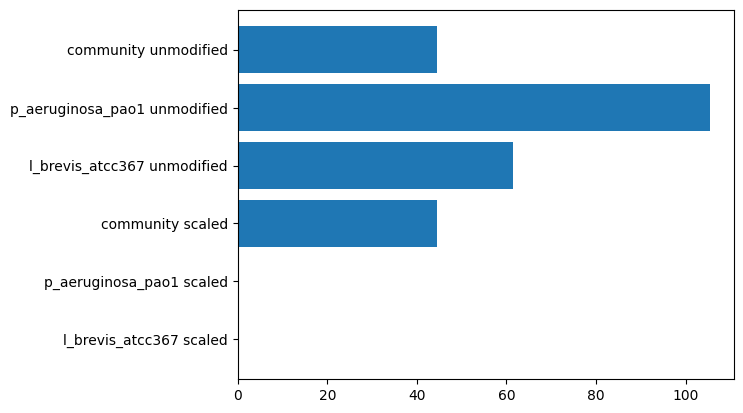

In [86]:
# Plotting the difference
import matplotlib.pyplot as plt
plt.barh(['l_brevis_atcc367 scaled', 'p_aeruginosa_pao1 scaled', 'community scaled', 'l_brevis_atcc367 unmodified', 'p_aeruginosa_pao1 unmodified', 'community unmodified'], benchmark_solutions)
print(benchmark_solutions)

In [95]:
# Manually scaling the models using only their first 2 entries
for rxn in l_brevis_essential[:2]['ids']:
    print(report_ec_number(l_brevis_atcc367, rxn), l_brevis_atcc367.reactions.get_by_id(rxn).reaction)
for rxn in p_aeruginosa_pao1_essential[:2]['ids']:
    print(report_ec_number(p_aeruginosa_pao1, rxn), p_aeruginosa_pao1.reactions.get_by_id(rxn).reaction)

2.4.2.11 h[c] + nac[c] + prpp[c] --> nicrnt[c] + ppi[c]
0.0.0.0 h2o[c] + h[c] + thdp[c] --> l2a6o[c]
2.1.1.222 2.1.1.64 2ohph[c] + amet[c] --> 2omph[c] + ahcys[c] + h[c]
4.6.1.12 2p4c2me[c] --> 2mecdp[c] + cmp[c]


The results show that the function `find_pivotal_reactions` is displaying the intended functionality and is therefore suitable for use in my project. However, the `update_thermodynamic_boundaries` function seems to be scaling either too many of the pivotal reactions or the default settings (pH = 7.0, default ATP and Mg2+ settings) may not be correlated with the conditions that prevail in the cell. Furthermore, I might have unintendedly used the default (instead of the modified) community for computing the growth rate of the **scaled community**. Nonetheless, the scaled community may approximated to be close to `0.0`, as the individual growth rates of the modified models are both exactly `0.0`. In conclusion, I will not be pursuing automatic thermodynamic scaling for Aim 1 for two reasons:
1. The scaling itself, even if deemed successful or mechanistically plausible, can introduce unwanted bias toward certain reactions and adopt my eariler simplifying assumption that the growth is dependent on thermodynamic constraints.
2. The `heuristic` value set (default is `40`) is inappropriate and may lead to inappropriate scaling.  

The constraints were, therefore, only manually checked (one example is shown below):

![alt text](image.png)

In order to ensure whether updating the constraints manually would confer any benefits, I checked the first two reactions for each of the two models. This time, the concentration of free $Mg^{2+}$ ions are set according to the number available on [Harvard Bionumbers](https://bionumbers.hms.harvard.edu/bionumber.aspx?id=115774). The default value for ionic strength was not altered due to it being close to the approximations on [Bionumbers](https://bionumbers.hms.harvard.edu/search.aspx?trm=ionic+strength+in+prokaryotic+cells).

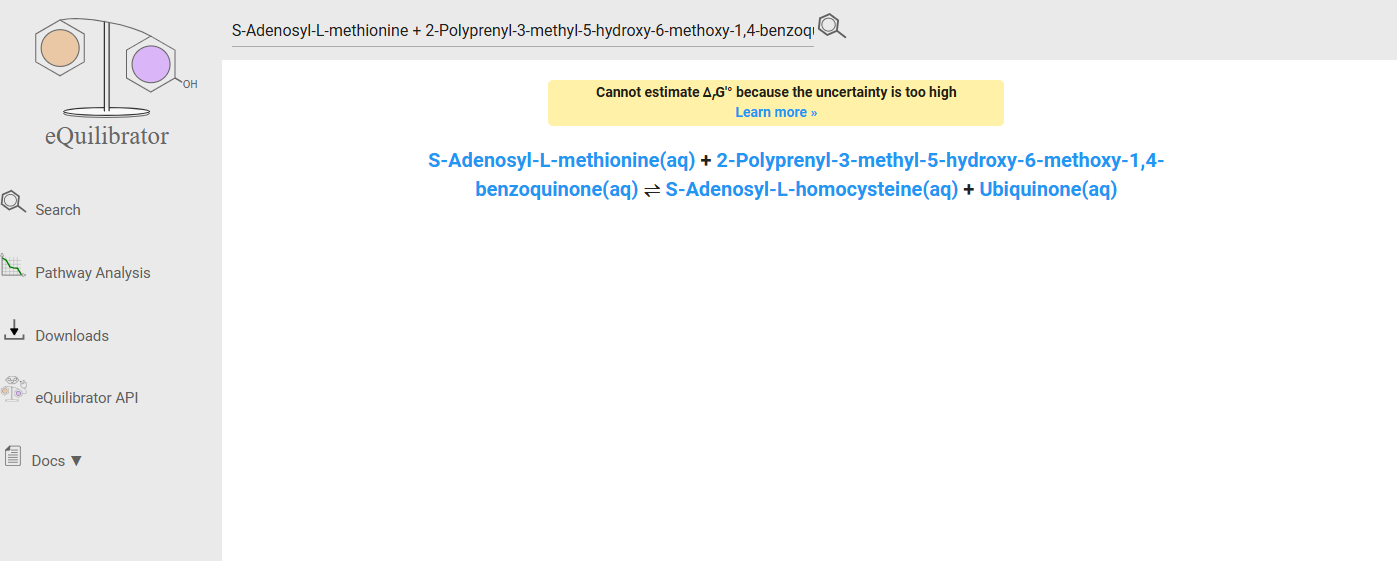

*Figure*. A screenshot of the search for the first essential reaction of *P. aeruginosa*, showing the error that I did not anticipate earlier. This was also true of the second essential reaction. 

In [ ]:
# No change to the first essential reaction of L. brevis, dg = 10.8 (error = 5.7) kJ/mol
# No change to the first essential reaction of P. aeruginosa due to the high uncertainty
# No change to the second essential reaction of P. aeruginosa due to the high uncertainty

As a last shot at thermodynamic constraint setup, I tried searching for the standard $\Delta G$ of key reactions in the glycolysis pathway, as glucose is the most prevalent substrate in the DFU medium I have simulated in `coculture_test_micom_small`.

In [103]:
# Searching for the PFK and PYK enzymes of the glycolysis pathway
find_rxn_met(l_brevis_atcc367, 'fructokinase')
find_rxn_met(l_brevis_atcc367, 'yruvate')
# Searching for the DOGDH enzyme of the ED pathway in P. aeruginosa


Found!
Name: Phosphofructokinase
ID: PFK
Reaction formula: atp[c] + f6p[c] --> adp[c] + fdp[c] + h[c]
Found!
Name: pyruvatethiamin diphosphate acetaldehydetransferase
ID: ACLS_a
Reaction formula: h[c] + pyr[c] + thmpp[c] --> co2[c] + hethmpp[c]
Found!
Name: 2-Acetolactate pyruvate-lyase (carboxylating)
ID: ACLS_b
Reaction formula: alac_S[c] + thmpp[c] <=> hethmpp[c] + pyr[c]
Found!
Name: pyruvate dehydrogenase (dihydrolipoamide) reversible
ID: PDHbr
Reaction formula: adhlam[c] + coa[c] <=> accoa[c] + dhlam[c]
Found!
Name: pyruvate dehydrogenase (dihydrolipoamide dehydrogenase)
ID: PDHc
Reaction formula: dhlam[c] + nad[c] --> h[c] + lpam[c] + nadh[c]
Found!
Name: phosphoenolpyruvate carboxykinase
ID: PPCK
Reaction formula: atp[c] + oaa[c] --> adp[c] + co2[c] + pep[c]
Found!
Name: Pyruvate Kinase
ID: PYK
Reaction formula: adp[c] + h[c] + pep[c] --> atp[c] + pyr[c]
Found!
Name: pyruvate oxidase
ID: PYROX
Reaction formula: h[c] + o2[c] + pi[c] + pyr[c] --> actp[c] + co2[c] + h2o2[c]


#### Effects of pH and Lactate on Enzyme Activity

For *P. aeruginosa* and *S. aureus*, the primary goal is to simulate how key reactions are downregulated or partially deactiviated as the [H+] and [Lactate] increases in the wound microenvironment. Thus, the `add_multitoxin` method of COMETSpy shall be used for these pivotal reactions in order to simulate the effects of lower pH on pathogen growth.

##### Enzyme Kinetics and Lactate

Generally speaking, an inhibitory effect on a classic Michaelis-Menten kinetic can represented as:
$$
v_i(t) := \frac{K_i}{K_i + [I]}
$$
Which may be integrated into the Michaelis-Menten formula ($v(t) = \frac{v_{max}[S]}{K_m + [S]}$):
$$
v'(t) := \frac{v_{max}[S]}{K_m + [S]}\frac{K_i}{K_i + [I]}
$$

This equation assumes a non-competative/mixed mode of enzyme inhibition.
The minimum inhibitory concentration (MIC) of lactate for inhibiting bacterial growth has been reported to be as high as 268 mM at pH 5.7 in one source concerning the use of sodium lactate as food preservative ([Houtsma et al., 1996](https://doi.org/10.4315/0362-028x-59.12.1300)) while, on the contrary, another paper has reported it to be about 9 mM when specifically considering its effect on *Listeria monocytogenes* in Gouda cheese and with a pH range of 5.2 to 5.8 ([Wemmenhove et al., 2016](http://dx.doi.org/10.1016/j.fm.2016.03.012)). In order to make sense of a reasonable inhibitory $\alpha'$ parameter, I will be basing my assumption on a value closer to the latter. I will be using 10 mM as the required lactate flux in order to determine its availability.

For fitting the lactate inhibition into a linear constraint, I will be using a Hill equation were there is no cooperativity (i.e. $n = 1$):
$$
v_i(t) := \frac{K_i^n}{K_i^n + [I]^n} = \frac{K_i}{K_i + [I]},\\
\text{where }[I]\text{ is the concentration of lactate.}
$$

In order to find an approximate $K_i$, I searched the following query in SABIO-RK:
```
Inhibitor:"L-lactate"
```
Consequently, for $K_i = 31.0 mM$ at a nearly neutral pH and as a non-competitive/uncompetitive inhibitor (for [L-alanine dehydrogenase](http://www.genome.jp/dbget-bin/www_bget?rn:R00396)),
$$
v_i(t) = \frac{31}{31 + [I]}
$$

The resulting function, when drawn as a curve, was:
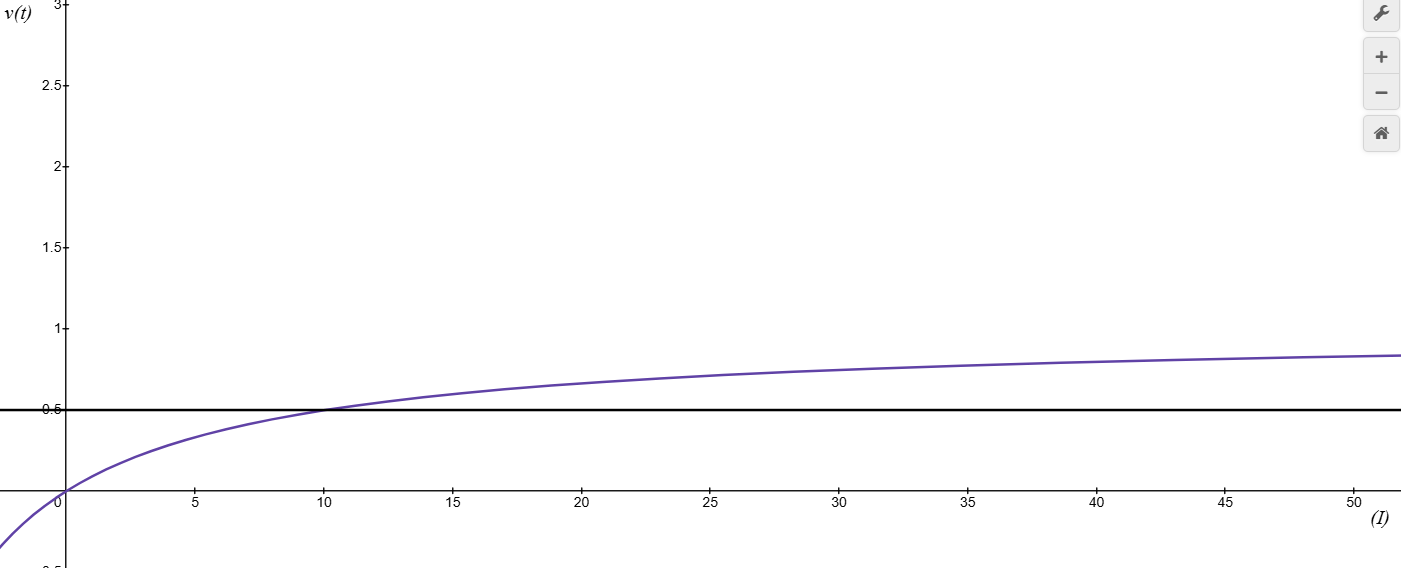

For $v = \frac{v_{max}[S]}{K_m + [S]}$. By assuming $v = v_{max}$ for the upper boundary, we again focus on lactate itself. Now, with the accumulation of lactate in the environment (i.e. larger flux from the medium), the inhibitory function can approximated using the line:
$$
v_{max}' = v_{max}(\frac{-1}{300}[I] + 1)
$$

Therefore, in restricting the biomass reaction we have the new constraint:
$$
v_{biomass} \leq v_{max}(1 - \frac{[I]}{300})
$$
Which can be rewritten as:
$$
v_{biomass} + v_{max}\frac{[I]}{300} \leq v_{max}
$$

In [ ]:
from optlang import Constraint, Variable

def add_metabolite_inhibition(model : cobra.Model, metabolite_restr = list[cobra.Reaction], restr_effect = 1, beta = 25,
                              biomass_rxn : cobra.Reaction | None = None, name = "L-lactate", essential_reactions : list | None = None):
    if (biomass_rxn): # Restrict biomass formation directly
        for met in metabolite_restr:
            # Storing the original biomass upper boundary
            v_max_orig = biomass_rxn.upper_bound
            # Declaring variables to hold the lactate concentration as a continuous value
            #I_lactate = Variable(metabolite_restr.flux_expression, lb=0, ub=restr_effect, type="continuous")
            inhibition_expr = restr_effect*met.flux_expression
            constraint_expr = biomass_rxn.flux_expression + (v_max_orig / beta) * inhibition_expr - v_max_orig
            inhibition_constraint = Constraint(constraint_expr, lb=-1e-6, ub=0, name = "Biomass_Inhibition_" + name)
            #inhibition_expr = restr_effect*metabolite_restr.flux_expression
            #inhibition_constraint = Constraint(biomass_rxn.flux_expression + restr_effect*metabolite_restr.flux_expression, lb=0, ub=100)
            model.add_cons_vars([inhibition_constraint])
            
    
    elif (essential_reactions and not biomass_rxn):
        raise NotImplementedError
        for reaction in essential_reactions:
            pass
            # Defining the equation parameters
            #v_max_orig = reaction.upper_bound   
            #L = measured_lactate                # the lactate concentration in the environment
            #L0 = 2.0               # baseline lactate with no inhibition, e.g., 2.0 mM
            #lambda_val = 1/300                    # sensitivity coefficient (units: flux unit per lactate unit)

            # Computing the adjusted upper bound
            #adjusted_upper_bound = v_max_orig - lambda_val * max(0, (L - L0))

            # Option 1: Directly reassign the reaction bound
            #reaction.upper_bound = adjusted_upper_bound

            # Option 2: Alternatively, you can add a constraint expression to link reaction flux and lactate:
            # Here we assume the lactate concentration is given as a parameter (or as a fixed value in the model).
            #expr = reaction.flux_expression + lambda_val * (L - L0)
            #lactate_inhibition_constraint = Constraint(expr, lb=-1e-6, ub=v_max_orig, name="Lactate_Inhibition")
            #model.solver.add(lactate_inhibition_constraint)
    else:
        print('No change will be applied!')

The following function (`create_lactate_demand`) introduces a new demand reaction resembling the left-hand side (i.e. the input) of the lactate reaction and creates an inhibitory effect on the cell whenever lactate is present. A more generalized version of this function (with the `waste` metabolite removed) is named `create_met_demand`.

In [105]:
from cobra import Reaction, Metabolite

def create_met_demand(model, biomass_rxn : Reaction, restr_effect = 1, met_id="lac_L(c)", demand_rxn_id="I_lactate", compartment="c"):
    """
    Creates a demand (sink) reaction for lactate.
    
    Parameters:
      model          : COBRApy model.
      met_id     : ID of the inhibitory metabolite (usually defined in the intracellular compartment).
      demand_rxn_id  : ID for the newly defined demand reaction.
      compartment    : Compartment for the waste metabolite.
      
    Returns:
      The created demand Reaction.
      Changes the model given as input.
    """
    # Fetching metabolite (if not present, raise an error or create it)
    try:
        i_metabolite = model.metabolites.get_by_id(met_id)
    except KeyError:
        i_metabolite = Metabolite(met_id, compartment=compartment)
        model.add_metabolites([i_metabolite])
    
    # Creating the demand (drain) reaction
    dm_rxn = Reaction(demand_rxn_id)
    dm_rxn.name = "Lactate Inhibition (Drain) Reaction"
    dm_rxn.lower_bound = 0   # irreversible drain (only consumption)
    dm_rxn.upper_bound = 1000  # arbitrary high value
    
    # Drain lactate: -1 metabolite gives nothing
    for met, val in biomass_rxn.metabolites.items():
        if (val < 0):
            dm_rxn.add_metabolites({met : restr_effect * val})
    model.add_reactions([dm_rxn])
    return dm_rxn


In [2]:
from cobra import Reaction, Metabolite

def create_lactate_demand(model, biomass_rxn : Reaction, restr_effect = 1, lactate_id="EX_lac_L(e)", demand_rxn_id="I_lactate", compartment="e"):
    """
    Creates a demand (sink) reaction for lactate.
    
    Parameters:
      model          : COBRApy model.
      lactate_id     : ID of the lactate exchange metabolite (usually defined in the extracellular compartment).
      demand_rxn_id  : ID for the newly defined demand reaction.
      compartment    : Compartment for the waste metabolite.
      
    Returns:
      The created demand Reaction.
      Changes the model given as input.
    """
    # Get lactate metabolite (if not present, raise an error or create it)
    try:
        lactate = model.metabolites.get_by_id(lactate_id)
    except KeyError:
        lactate = Metabolite(lactate_id, compartment=compartment)
        model.add_metabolites([lactate])
    
    # Create a "waste" metabolite if not already present
    waste_id = "waste"
    if waste_id in model.metabolites:
        waste = model.metabolites.get_by_id(waste_id)
    else:
        waste = Metabolite(waste_id, compartment=compartment)
        model.add_metabolites([waste])
    
    # Create the demand (drain) reaction
    dm_rxn = Reaction(demand_rxn_id)
    dm_rxn.name = "Lactate Inhibition (Drain) Reaction"
    dm_rxn.lower_bound = 0   # irreversible drain (only consumption)
    dm_rxn.upper_bound = 1000  # arbitrary high value
    
    # Drain lactate: -1 lactate gives +1 waste (this stoichiometry is adjustable)
    for met, val in biomass_rxn.metabolites.items():
        if (val < 0):
            dm_rxn.add_metabolites({met : restr_effect * val})
    model.add_reactions([dm_rxn])
    return dm_rxn


It is possible to formluate inhibitory constraints for other metaoblites as well, namely acetate, propionate, and formate. For instance, by assuming a rather conservative approximation of acetate's MIC for *P. aeruginosa* (as per the work of [Tawre et al., 2021](https://doi.org/10.1371/journal.pone.0246020)):
$$
MIC_{acetate} = 0.16 \text{ percent v/v} \rightarrow c_{acetate} = 0.16/59 \times 0.01 \times 1000
$$

##### Evaluating Lactate Sensitivity of *P. aeruginosa*

In order to confirm that the `create_lactate_demand` and `create_met_demand` are working as intended, I will plot the differences in biomass growth in the unmodified `p_aeruginosa` model object and assess the difference between each 'treatment'.

In [106]:
# Loading seaborn and matplotlib.pyplot libraries to plot the change
import seaborn as sns
import matplotlib.pyplot as plt

In [107]:
# Loading the model as p_aeruginosa
p_aeruginosa = cobra.io.read_sbml_model(models_dictionary['p_aeruginosa_pao1'])

In [128]:
p_aeruginosa_mod = p_aeruginosa_pao1.copy()
create_met_demand(p_aeruginosa_mod, p_aeruginosa_mod.reactions.bio1, 100)
print(p_aeruginosa_mod.reactions.I_lactate)

I_lactate: 0.79397 10fthf[c] + 0.79397 2dmmq8[c] + 0.79397 5mthf[c] + 0.79397 ACP[c] + 0.18061 PGP[c] + 0.79397 adocbl[c] + 26.756 ala_L[c] + 0.79397 amet[c] + 19.34 arg_L[c] + 14.832999999999998 asn_L[c] + 14.832999999999998 asp_L[c] + 4129.14 atp[c] + 0.79397 ca2[c] + 0.79397 cl[c] + 0.8587100000000001 clpn180[c] + 0.8587100000000001 clpnai17[c] + 0.8587100000000001 clpni17[c] + 0.79397 coa[c] + 0.79397 cobalt2[c] + 2.5039 colipa[c] + 2.6124 ctp[c] + 0.79397 cu2[c] + 5.695399999999999 cys_L[c] + 0.90279 datp[c] + 1.7841 dctp[c] + 1.7841 dgtp[c] + 100.0 dnarep[c] + 2.504 dtdprmn[c] + 0.90279 dttp[c] + 0.79397 fad[c] + 0.79397 fe2[c] + 0.79397 fe3[c] + 26.1 gln_L[c] + 26.1 glu_L[c] + 40.933 gly[c] + 0.79397 gthrd[c] + 4.2403 gtp[c] + 4125.7 h[c] + 8.194799999999999 his_L[c] + 27.043 ile_L[c] + 0.79397 k[c] + 2.504 kdo2lipid4L[c] + 34.746 leu_L[c] + 32.37 lys_L[c] + 11.35 met_L[c] + 0.79397 mg2[c] + 0.79397 mn2[c] + 0.79397 mqn8[c] + 0.79397 nad[c] + 0.79397 nadp[c] + 0.8587100000000001

In [129]:
print(p_aeruginosa_mod.reactions.bio1)

bio1: 0.0079397 10fthf[c] + 0.0079397 2dmmq8[c] + 0.0079397 5mthf[c] + 0.0079397 ACP[c] + 0.0018061 PGP[c] + 0.0079397 adocbl[c] + 0.26756 ala_L[c] + 0.0079397 amet[c] + 0.1934 arg_L[c] + 0.14833 asn_L[c] + 0.14833 asp_L[c] + 41.2914 atp[c] + 0.0079397 ca2[c] + 0.0079397 cl[c] + 0.0085871 clpn180[c] + 0.0085871 clpnai17[c] + 0.0085871 clpni17[c] + 0.0079397 coa[c] + 0.0079397 cobalt2[c] + 0.025039 colipa[c] + 0.026124 ctp[c] + 0.0079397 cu2[c] + 0.056954 cys_L[c] + 0.0090279 datp[c] + 0.017841 dctp[c] + 0.017841 dgtp[c] + dnarep[c] + 0.02504 dtdprmn[c] + 0.0090279 dttp[c] + 0.0079397 fad[c] + 0.0079397 fe2[c] + 0.0079397 fe3[c] + 0.261 gln_L[c] + 0.261 glu_L[c] + 0.40933 gly[c] + 0.0079397 gthrd[c] + 0.042403 gtp[c] + 41.257 h[c] + 0.081948 his_L[c] + 0.27043 ile_L[c] + 0.0079397 k[c] + 0.02504 kdo2lipid4L[c] + 0.34746 leu_L[c] + 0.3237 lys_L[c] + 0.1135 met_L[c] + 0.0079397 mg2[c] + 0.0079397 mn2[c] + 0.0079397 mqn8[c] + 0.0079397 nad[c] + 0.0079397 nadp[c] + 0.0085871 pe180[c] + 0.00

In [108]:
# Confirming that p_aeruginosa.bio1 biomass objective exists
p_aeruginosa.reactions.bio1.metabolites

{<Metabolite 10fthf[c] at 0x256ec51c200>: -0.0079397,
 <Metabolite 2dmmq8[c] at 0x256e0ea70b0>: -0.0079397,
 <Metabolite 5mthf[c] at 0x256e0242240>: -0.0079397,
 <Metabolite ACP[c] at 0x256e0eb62a0>: -0.0079397,
 <Metabolite PGP[c] at 0x256e0fed490>: -0.0018061,
 <Metabolite adocbl[c] at 0x256e4e5f050>: -0.0079397,
 <Metabolite ala_L[c] at 0x256e4eabfb0>: -0.26756,
 <Metabolite amet[c] at 0x256e0fa4cb0>: -0.0079397,
 <Metabolite arg_L[c] at 0x256e0341a90>: -0.1934,
 <Metabolite asn_L[c] at 0x256e060c2f0>: -0.14833,
 <Metabolite asp_L[c] at 0x256e4221a00>: -0.14833,
 <Metabolite atp[c] at 0x256e0e7cc50>: -41.2914,
 <Metabolite ca2[c] at 0x256e0f69100>: -0.0079397,
 <Metabolite cl[c] at 0x256dfdfb260>: -0.0079397,
 <Metabolite clpn180[c] at 0x256e0eaa360>: -0.0085871,
 <Metabolite clpnai17[c] at 0x256e0eaa900>: -0.0085871,
 <Metabolite clpni17[c] at 0x256e4cbb0e0>: -0.0085871,
 <Metabolite coa[c] at 0x256e0eca180>: -0.0079397,
 <Metabolite cobalt2[c] at 0x256e05b2690>: -0.0079397,
 <Meta

In [109]:
# Optional: Loading the previously-defined DFU medium to simulate under physiological conditions
import pandas as pd

def load_medium(file_path = '../env/dfu_medium.csv'):
    dfu_df = pd.read_csv(file_path)
    dfu_dict = dfu_df.to_dict(orient='list')
    for e, f in zip(dfu_dict['exchange'], dfu_dict['flux']):
        e = e.replace('_m', '(e)')
        dfu_dict[e] = f
    dfu_dict.pop('exchange')
    dfu_dict.pop('flux')
    return dfu_dict

In [194]:
# Creating a minimal growth medium and storing the DFU-resembling medium
modified_med = cobra.medium.minimal_medium(p_aeruginosa, 0.3)
dfu_med = load_medium()

In [207]:
# Creating a copy of the loaded model to preserve it
def plot_metabolite_sensitivity(model : cobra.Model, medium : dict,
                                target_rxn : cobra.Reaction,
                                target_met = ['lac_L(c)', 'lac_D(c)'],
                                target_min_max = (0, 10000),
                                target_exchanges = ['EX_lac_L(e)', 'EX_lac_D(e)'],
                                restr_effect = [0.1, 1, 10, 100, 1000, 10000, 100000],
                                report_difference = False,
                                enforce_changes = False):
    modified_model = model.copy()
    # Declaring list variables to hold all of the growth values
    low_values, high_values = [], []
    # Modifying the model for each restr_effect parameter
    for re in restr_effect:
        new_reactions = []
        for met in target_met:
            new_reactions.append(create_met_demand(modified_model, target_rxn, restr_effect=re, met_id=met, demand_rxn_id='I_'+met))
        # Confirming the inhibitory effect after modification
        # Storing the reactions in a modified medium dictionary
        modified_med = {}
        for key, value in medium.items():
            if (key in modified_model.medium.keys()):
                modified_med[key] = value
        for met in target_exchanges:
            modified_med[met] = target_min_max[1]
        modified_model.medium = modified_med
        # Storing the high metabolite growth
        high_values.append(modified_model.slim_optimize())

        for met in target_exchanges:
            modified_med[met] = target_min_max[0]
        modified_model.medium = modified_med
        # Storing the low metabolite growth
        low_values.append(modified_model.slim_optimize())
        # Removing the modifications to avoid confounding for different restr_effect
        modified_model.remove_reactions(new_reactions)
    # Applying the best modification if the enforce_changes is True
    best_restr_effect = -1
    # Creating subplots and plotting each of the results
    #ax_high = plt.subplot(121)
    #ax_low = plt.subplot(121)
    #ax_high.plot(restr_effect, high_values)
    #ax_high.set_xscale('log')
    #ax_low.plot(restr_effect, low_values)
    #ax_low.set_xscale('log')
    if report_difference:
        # Computes the difference in growth resulting from the inhibitory reaction
        diff_in_growth = [x - y for x, y in zip(low_values, high_values)]
        plt.plot(restr_effect, diff_in_growth)
        plt.title('Impact of Restriction Parameter on Growth')
        plt.xscale('log')
        plt.xlabel(f'Restriction Parameter on {target_exchanges}')
        plt.ylabel('Difference in Growth')
        if (enforce_changes):
            best_restr_effect = max(diff_in_growth)
        print(diff_in_growth)
    else:
        plt.plot(restr_effect, high_values)
        print(high_values)
        plt.plot(restr_effect, low_values)
        print(low_values)
        plt.title('Impact of Restriction Parameter on Growth')
        plt.xscale('log')
        plt.xlabel(f'Restriction Parameter on {target_exchanges}')
        plt.ylabel('Model Growth')
    if (best_restr_effect >= 0 and enforce_changes):
        for met in target_met:
            create_met_demand(model, target_rxn, re, met_id=met, demand_rxn_id='I_' + met)

[7.921441280700492e-14, -1.8762769116165146e-14, -2.6018076582090544e-13, -3.924083280537616e-13, 5.551115123125783e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]


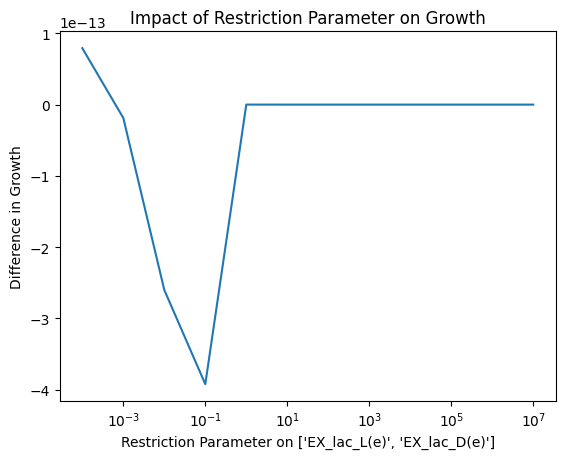

In [198]:
plot_metabolite_sensitivity(p_aeruginosa, cobra.medium.minimal_medium(p_aeruginosa, 0.3),
                            p_aeruginosa.reactions.bio1, report_difference= True,
                            restr_effect=[10**x for x in range(-4, 8)])
print([10**x for x in range(-4, 8)])

[5.708308562951256e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]


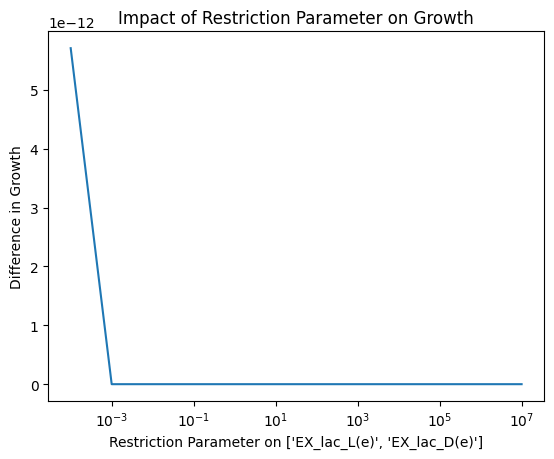

In [208]:
# Plotting the growth restriction effect for when the bacterium is on a DFU
plot_metabolite_sensitivity(p_aeruginosa, dfu_med,
                            p_aeruginosa.reactions.bio1, report_difference= True,
                            restr_effect=[10**x for x in range(-4, 8)])
print([10**x for x in range(-4, 8)])

Drawing on the resulting plot, the restriction parameter `restr_effect = 0.0001` is a suitable inhibition (called "restriction" here) coefficient. In contrast to the linear approximation of L-lactate derived earlier, this inhibitory parameter and the so called "inhibition" reaction to which it pertains do not imply any real empirical concept, serving solely to *calibrate* the model to represent the generalized inhibitory effects of lactate on the organism's growth. 

##### The Effects of Acidity on Enzyme Activity

The functions below were initially implemented with the help of Microsoft Copilot AI to model the inhibitory effects of low pH (i.e. high acidity) on enzyme activity. For now, all of my attempts in getting the following functions to run properly. Hence, I have postponed their complete implemntation to Aim 2.

In [ ]:
from optlang import Variable, Constraint, Objective
import numpy as np

def p(proton, adjust):
    # Since the flux can vary from -1000 to 1000, to say that every flux unit is equivalent to h+ mmol flux would result in out-of-context values
    # (e.g. pH = 0 for h+ = -1000 or 1000 mmol inside)
    output = np.log10(proton)
    output = -output
    return output

def pH_sensitivity(h_current, h_ref, sigma = 1, alpha = 0.1, linear = True):
    """
    Computes the pH sensitivity of any given enzyme/reaction.
    """
    if linear:
        return (alpha * (h_current - h_ref))
    else:
        return (np.exp(-(p(h_current) - p(h_ref)) ** 2) / 2*(sigma**2))
    
def apply_sensitivity():
    pass

def update_model_constraints():
    pass

### *Lactobacillus brevis* ATCC 367

In [107]:
# Import read_sbml_model function for loading the model
from cobra.io import read_sbml_model
import cobra.io
# Loading the model and displaying it
l_brevis_atcc367 = read_sbml_model(models_dictionary['l_brevis_atcc367'])
l_brevis_atcc367

Name,M_Lactobacillus_brevis_ATCC_367
Memory address,2196d74f6b0
Number of metabolites,1597
Number of reactions,1865
Number of genes,565
Number of groups,68
Objective expression,1.0*biomass525 - 1.0*biomass525_reverse_5c178
Compartments,"Cytoplasm, Extracellular"


In [108]:
solution = l_brevis_atcc367.optimize()
l_brevis_atcc367.summary(solution)

Metabolite,Reaction,Flux,C-Number,C-Flux
ade[e],EX_ade(e),13.58,5,0.16%
arg_L[e],EX_arg_L(e),17.72,6,0.24%
asn_L[e],EX_asn_L(e),14.43,4,0.13%
asp_L[e],EX_asp_L(e),20.11,4,0.19%
ca2[e],EX_ca2(e),0.48,0,0.00%
cl[e],EX_cl(e),0.48,0,0.00%
cobalt2[e],EX_cobalt2(e),0.48,0,0.00%
csn[e],EX_csn(e),17.33,4,0.16%
cu2[e],EX_cu2(e),0.48,0,0.00%
cys_L[e],EX_cys_L(e),6.429,3,0.04%


In [140]:
# Saving an JSON format of the model to view it in CellDesigner
# UPDATE: I just realized that CellDesigner does not support the use of SMBL3v1 metabolic models, yet I will keep the cell for future reference
# and use with other platforms (e.g. MATLAB) and tools.
cobra.io.save_json_model(l_brevis_atcc367, PATH + '/' + 'l_brevis_atcc367.json')

Most likely, due to the large size of the models I have used in this project, Escher's viewport cannot effectively build and load a visualization of the entire model. Therefore, I have only used .. for visualizing one of the models (*L. brevis* ATCC 367).

In [112]:
# Viewing the model in Escher
import escher
from escher import Builder

# Turns off the warning message when leaving or refreshing this page.
# The default setting is False to help avoid losing work.
escher.rc['never_ask_before_quit'] = True
viz_l_brevis = Builder(
    model_json = '../model_data/l_brevis_atcc367.json',
    map_json = '../model_data/l_brevis_atcc367.json'
)
viz_l_brevis.save_html('../model_data/l_brevis_atcc367.html')

Here is the visualized version of the *L. brevis* model:


### *Lactobacillus plantarum* WCFS1

As it can be seen in the summary of uptake and secretion reactions, the homofermentative nature of this strain (while *inducibly* heterofermentative) can be reinforced by manually restricting the reactions for acetate and ethanol production.


(a) Metabolism by pyruvate formate lyase. Equal proportions of pyruvate are reduced to ethanol to regenerate reduced co-factors, or oxidized to acetate to synthesize ATP. Pyruvate formate lyase is inhibited by an abundant substrate supply and by low pH, and is inactivated by oxygen 3, 7, 9.

In [141]:
# Importing read_sbml_model function
from cobra.io import read_sbml_model
import cobra.io
# Loading the model and displaying it
l_plantarum_wcfs1 = read_sbml_model(models_dictionary['l_plantarum_wcfs1'])
l_plantarum_wcfs1

Name,M_Lactobacillus_plantarum_WCFS1
Memory address,256f8e9dc70
Number of metabolites,1083
Number of reactions,1245
Number of genes,902
Number of groups,74
Objective expression,1.0*biomass524 - 1.0*biomass524_reverse_2f2dd
Compartments,"Cytoplasm, Extracellular"


In [142]:
solution = l_plantarum_wcfs1.optimize()
l_plantarum_wcfs1.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
7a_czp[e],EX_7a_czp(e),565.9,15,41.27%
acnam[e],EX_acnam(e),38.09,11,2.04%
alaasp[e],EX_alaasp(e),10.38,7,0.35%
alathr[e],EX_alathr(e),15.77,7,0.54%
arg_L[e],EX_arg_L(e),16.32,6,0.48%
ca2[e],EX_ca2(e),1.454,0,0.00%
cl[e],EX_cl(e),1.454,0,0.00%
cobalt2[e],EX_cobalt2(e),1.454,0,0.00%
cu2[e],EX_cu2(e),1.454,0,0.00%
fe2[e],EX_fe2(e),2.908,0,0.00%


In [143]:
# Searching for the reactions containing acetate and ethanol products or precursors
find_rxn_met(l_plantarum_wcfs1, None, 'Acetate') # Searching for 'acetate'
find_rxn_met(l_plantarum_wcfs1, None, 'Ethanol') # Searching for 'ethanol'
find_rxn_met(l_plantarum_wcfs1, 'actate oxidase')

Found!
Name: Acetate
ID: ac[c]
Related reaction: ACLYSHYc Hydrolysis of Acetyl-Lysine aclys[c] + h2o[c] <=> ac[c] + lys_L[c]
Related reaction: AHSERL3 O-Acetyl-L-homoserine acetate-lyase achms[c] + trdrd[c] + tsul[c] <=> ac[c] + h[c] + hcys_L[c] + so3[c] + trdox[c]
Related reaction: CITL Citrate Lyase cit[c] --> ac[c] + oaa[c]
Related reaction: METB1 O-Acetyl-L-homoserine succinate-lyase (adding cysteine) achms[c] + cys_L[c] --> ac[c] + cyst_L[c] + h[c]
Related reaction: DAPDAi N-acetyl-L,L-diaminopimelate deacetylase irreversible h2o[c] + n6all26d[c] --> 26dap_LL[c] + ac[c]
Related reaction: ACODAr Acetylornithine deacetylase, reversible acorn[c] + h2o[c] <=> ac[c] + orn[c]
Related reaction: AHSERL2 O-acetylhomoserine (thiol)-lyase achms[c] + h2s[c] --> ac[c] + h[c] + hcys_L[c]
Related reaction: ALDD2x Aldehyde Dehydrogenase (Acetaldehyde, NAD) acald[c] + h2o[c] + nad[c] --> ac[c] + 2.0 h[c] + nadh[c]
Related reaction: ACtr acetate transporter ac[e] <=> ac[c]
Related reaction: ACKr ac

Based on the found entries, the best reactions to knockout for switching from hetero- to homolactic fermentation are:

|   Acetate pathway     |   Ethanol pathway     |
|   Aldehyde dehydrogenase (ALDD2x) |   Alcohol dehydrogenase (ALCD2x) |

Many LAB are conditionally respiring [14]. LAB are auxotroph for heme (all LAB) and menaquinone (some LAB) but the availability of heme (and menaquinone) in the fermentation substrate supports cofactor recycling and proton export by respiration (Figure 3d) [15]. Respiration shifts homofermentative metabolism towards acetate and acetoin as major metabolites (Figure 4) 6, 16. ([Gänzle, 2015](https://www.sciencedirect.com/science/article/pii/S2214799315000508)).

In [172]:
# Knocking out aldehyde dehydrogenase and alcohol dehydrogenase
l_plantarum_wcfs1.reactions.get_by_id('ALDD2x').lower_bound = -800
l_plantarum_wcfs1.reactions.get_by_id('ALDD2x').upper_bound = 800

l_plantarum_wcfs1.reactions.get_by_id('ALCD2x').lower_bound = -5
l_plantarum_wcfs1.reactions.get_by_id('ALCD2x').upper_bound = 5

In [173]:
# Reoptimizing the modified model
l_plantarum_wcfs1.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
acnam[e],EX_acnam(e),38.67,11,3.02%
alathr[e],EX_alathr(e),16.01,7,0.80%
anzp[e],EX_anzp(e),227.3,15,24.24%
arg_L[e],EX_arg_L(e),16.57,6,0.71%
ca2[e],EX_ca2(e),1.476,0,0.00%
cit[e],EX_cit(e),53.68,6,2.29%
cl[e],EX_cl(e),1.476,0,0.00%
cobalt2[e],EX_cobalt2(e),1.476,0,0.00%
cu2[e],EX_cu2(e),1.476,0,0.00%
fe2[e],EX_fe2(e),2.953,0,0.00%


To my surprise and to my fortune, by greatly restricting ethanol production (however preserving it to simulate leakiness and the cumulative effect of transient phases of heterolactic fermentation) and slightly decreasing acetate production (to reduce the carbon flux of acetate while still allowing for acetate consumption and ATP production to take place), the model's growth is increased by 0.1 and a third of the carbon flux (shown as `C-flux`) is shunted to lactate production. Therefore, the model's new constraints are saved in a SBML file for future use.

In [175]:
import os
cobra.io.save_json_model(l_plantarum_wcfs1, PATH + '/' + 'l_plantarum_wcfs1.json')
os.rename('../model_data/Lactobacillus_plantarum_WCFS1.xml', '../model_data/Lactobacillus_plantarum_WCFS1_Unmod.xml') # Renaming the previous model to preserve it
cobra.io.write_sbml_model(l_plantarum_wcfs1, '../model_data/Lactobacillus_plantarum_WCFS1.xml') # Saving the modified model with the same name

### *Lactobacillus plantarum* JDM1
-- *Largely derived from Perplexity AI ([Link](https://www.perplexity.ai/search/how-much-acetate-and-ethanol-d-TEJ.7ZzlSbS0L31HEFTymA#2))* --

Compared to the WCFS1 strain, *L. plantarum* JDM1 has a slightly contracted genome, two plasmids, and a number of prophages that vary in between individual bacteria. A shorter genome for JDM1 has partly been attributed to its loss of some sugar metabolism genes present in WCFS1, which might render it metabolically more inclined towards homolactic fermentation ([Zhang et al., 2009](https://journals.asm.org/doi/10.1128/jb.00587-09)). Therefore, I have greatly restricted the constraints for both ethanol and acetate production.  

Quoting from [Zhang et al., 2009](https://journals.asm.org/doi/10.1128/jb.00587-09), "with the development of better living conditions, the biosafety of food and medicine has received more attention. *Lactobacillus* bacteria have been supposed to have a “generally accepted as safe” status, but they still have been associated with negative reports."

In [227]:
# Import read_sbml_model function for loading the model
from cobra.io import read_sbml_model
import cobra.io
# Loading the model and displaying it
l_plantarum_jdm1 = read_sbml_model(models_dictionary['l_plantarum_jdm1'])
l_plantarum_jdm1

Name,M_Lactobacillus_plantarum_JDM1
Memory address,2569b5b76e0
Number of metabolites,1087
Number of reactions,1269
Number of genes,901
Number of groups,75
Objective expression,1.0*biomass205 - 1.0*biomass205_reverse_3c9be
Compartments,"Cytoplasm, Extracellular"


In [228]:
solution = l_plantarum_jdm1.optimize()
l_plantarum_jdm1.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
4abz[e],EX_4abz(e),1.615,7,0.05%
7a_czp[e],EX_7a_czp(e),671.8,15,45.67%
arg_L[e],EX_arg_L(e),13.12,6,0.36%
ca2[e],EX_ca2(e),0.5384,0,0.00%
cl[e],EX_cl(e),0.5384,0,0.00%
cobalt2[e],EX_cobalt2(e),0.5384,0,0.00%
cu2[e],EX_cu2(e),0.5384,0,0.00%
cys_L[e],EX_cys_L(e),5.478,3,0.07%
fe2[e],EX_fe2(e),1.615,0,0.00%
gam[e],EX_gam(e),13.47,6,0.37%


In [229]:
# Searching for reactions involving acetate and ethanol
find_rxn_met(l_plantarum_jdm1, metabolite='Acetate')
find_rxn_met(l_plantarum_jdm1, metabolite='Ethanol')

Found!
Name: Acetate
ID: ac[c]
Related reaction: CYSS cysteine synthase acser[c] + h2s[c] --> ac[c] + cys_L[c] + h[c]
Related reaction: AGDC N-Acetylglucosamine-6-Phosphate Deacetylase acgam6p[c] + h2o[c] --> ac[c] + gam6p[c]
Related reaction: ACtr acetate transporter ac[e] <=> ac[c]
Related reaction: DAPDAi N-acetyl-L,L-diaminopimelate deacetylase irreversible h2o[c] + n6all26d[c] --> 26dap_LL[c] + ac[c]
Related reaction: AHSERL2 O-acetylhomoserine (thiol)-lyase achms[c] + h2s[c] --> ac[c] + h[c] + hcys_L[c]
Related reaction: CYSS3r cysteine synthase (Thiosulfate) acser[c] + trdrd[c] + tsul[c] <=> ac[c] + cys_L[c] + h[c] + so3[c] + trdox[c]
Related reaction: AMID4 amidase ad[c] + h2o[c] --> ac[c] + nh4[c]
Related reaction: METB1 O-Acetyl-L-homoserine succinate-lyase (adding cysteine) achms[c] + cys_L[c] --> ac[c] + cyst_L[c] + h[c]
Related reaction: CITL Citrate Lyase cit[c] --> ac[c] + oaa[c]
Related reaction: ACKr acetate kinase ac[c] + atp[c] <=> actp[c] + adp[c]
Related reaction: 

In [230]:
# Knocking out acetate kinase and alcohol dehydrogenase
l_plantarum_jdm1.reactions.get_by_id('ACKr').lower_bound = -750
l_plantarum_jdm1.reactions.get_by_id('ACKr').upper_bound = 750

l_plantarum_jdm1.reactions.get_by_id('ALCD2x').lower_bound = 0
l_plantarum_jdm1.reactions.get_by_id('ALCD2x').upper_bound = 0

In [231]:
# Checking for changes to the carbon flux and the growth rate of the model
l_plantarum_jdm1.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
4abz[e],EX_4abz(e),1.517,7,0.06%
anzp[e],EX_anzp(e),545.4,15,42.49%
arg_L[e],EX_arg_L(e),12.31,6,0.38%
ca2[e],EX_ca2(e),0.5056,0,0.00%
cit[e],EX_cit(e),36.25,6,1.13%
cl[e],EX_cl(e),0.5056,0,0.00%
cobalt2[e],EX_cobalt2(e),0.5056,0,0.00%
cu2[e],EX_cu2(e),0.5056,0,0.00%
cys_L[e],EX_cys_L(e),5.143,3,0.08%
fe2[e],EX_fe2(e),1.517,0,0.00%


In [232]:
import os
cobra.io.save_json_model(l_plantarum_jdm1, PATH + '/' + 'l_plantarum_jdm1.json')
os.rename('../model_data/Lactobacillus_plantarum_JDM1.xml', '../model_data/Lactobacillus_plantarum_JDM1_Unmod.xml') # Renaming the previous model to preserve it
cobra.io.write_sbml_model(l_plantarum_jdm1, '../model_data/Lactobacillus_plantarum_JDM1.xml') # Saving the modified model with the same name

### *Staphylococcus aureus* USA300

*Staphylococcus aureus* USA300, which is, like *Pseudomonas aeruginosa*, one of the most commonly acquired nosocomial pathogens and was first isolated in the United States. Its more resilient counterpart, *S. aureus* USA300 FPR3757 shows more resistance to pH change and antibiotic treatments.

In [190]:
# Loading the essential libraries
import cobra
import pandas as pd

In [209]:
# Loading the model for P. aeruginosa
s_aureus_usa300 = cobra.io.read_sbml_model(models_dictionary['s_aureus_usa300'])
s_aureus_usa300.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
12dgr180[e],EX_12dgr180(e),3.766,39,0.11%
26dap_M[e],EX_26dap_M(e),29.49,7,0.15%
3mop[e],EX_3mop(e),39.56,6,0.17%
4abz[e],EX_4abz(e),2.158,7,0.01%
acisnzd[e],EX_acisnzd(e),1000,8,5.84%
actn_R[e],EX_actn_R(e),58.65,4,0.17%
adocbl[e],EX_adocbl(e),1000,72,52.52%
akg[e],EX_akg(e),908.7,5,3.31%
ala_L[e],EX_ala_L(e),7.476,3,0.02%
alathr[e],EX_alathr(e),16.93,7,0.09%


[7.991717656896488e-15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


TypeError: can't multiply sequence by non-int of type 'float'

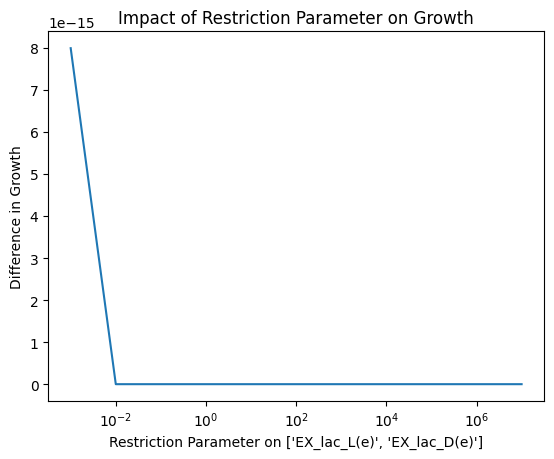

In [203]:
plot_metabolite_sensitivity(s_aureus_usa300, dfu_med,
                            s_aureus_usa300.reactions.biomass042, report_difference= True,
                            restr_effect=[10**x for x in range(-3, 8)], enforce_changes=True) # When setting the enforce_changes to True, the model is modified as it is plotted
print([10**x for x in range(-3, 8)])

In [212]:
import os
cobra.io.save_json_model(s_aureus_usa300, PATH + '/' + 's_aureus_usa300.json')
os.rename(models_dictionary['s_aureus_usa300'], models_dictionary['s_aureus_usa300'].replace('.xml', '_Unmod.xml')) # Renaming the previous model to preserve it
cobra.io.write_sbml_model(s_aureus_usa300, models_dictionary['s_aureus_usa300']) # Saving the modified model with the same name

### *Pseudomonas aeruginosa* PAO1

Herein, the models for *P. aeruginosa* PAO1 and NCGM2_S1 (hereafter referred to as 'PAO1' and 'NCGM2_S1', respectively) are loaded and a summary is investigated. Generally, PAO1 is a well-studied lab strain that was first isolated and characterized in 1950s and has eversince undergone some change in the lab. It is worth noting that PAO1 is relatively pH-sensitive and still sensitive to a wider range of drugs compared to the other strain introduced, NCGM2_S1. This latter strain is a more recent isolation and is far more resilient to pH change and organic acid-related stresses. Therefore, as a proof-of-concept, I chose to use the first model as a part of my Aim 1.

In [213]:
# Loading the essential libraries
import cobra
import pandas as pd

In [214]:
# Loading the model for P. aeruginosa
p_aeruginosa_pao1 = cobra.io.read_sbml_model(models_dictionary['p_aeruginosa_pao1'])
p_aeruginosa_pao1.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
34dhpha[e],EX_34dhpha(e),805.5,8,4.66%
5fura[e],EX_5fura(e),1000,4,2.89%
acald[e],EX_acald(e),1000,2,1.45%
acisnzd[e],EX_acisnzd(e),1000,8,5.78%
adocbl[e],EX_adocbl(e),9.604,72,0.50%
akg[e],EX_akg(e),75.58,5,0.27%
arg_L[e],EX_arg_L(e),1000,6,4.34%
asn_L[e],EX_asn_L(e),15.64,4,0.05%
bzd[e],EX_bzd(e),1000,17,12.28%
ca2[e],EX_ca2(e),0.8374,0,0.00%


In [20]:
cobra.flux_analysis.single_reaction_deletion(p_aeruginosa_pao1)

,ids,growth,status
0,{3OAR4M6},0.000000e+00,optimal
1,{3OAR12M13},1.054659e+02,optimal
2,{4GBTAH},1.054659e+02,optimal
3,{PDX5PSYN},3.476358e-14,optimal
4,{OPHHX3},1.054659e+02,optimal
...,...,...,...
2150,{OPMNHL},1.054659e+02,optimal
2151,{ALAASPabcpp},1.054659e+02,optimal
2152,{PGPP120},1.054659e+02,optimal
2153,{ZNabcpp},1.054659e+02,optimal


By calling the `find_pivotal_reactions`, the top `0.12` or 12% reactions the deletion of which adversely affects model growth are extracted and **rate-limiting** reactions in the model can be found. The constraints of these reactions will be the prime choice for the fine-tuning phase. As it will be later discussed, the database used for this will be `eQuilibrator`.

In [122]:
pivotal_reactions = find_pivotal_reactions(p_aeruginosa_pao1, 0.12)

In [123]:
# Displaying the found pivotal reactions for P. aeruginosa and saving them
pivotal_reactions.to_csv('../model_finetuning/p_aeruginosa_pao1_essential_reactions.csv')
pivotal_reactions

,ids,growth,name,status
7,OPHBDC,-6.110314e-11,Octaprenyl-hydroxybenzoate decarboxylase,optimal
196,METAT,-5.270098e-11,Methionine Adenosyltransferase,optimal
74,AHC,-3.216317e-11,Adenosylhomocysteinase,optimal
69,HBZOPT,-2.472982e-11,Hydroxybenzoate octaprenyltransferase,optimal
61,OHPHM,-2.466931e-11,2-octaprenyl-6-hydroxyphenol methylase,optimal
10,FMNAT,-2.462539e-11,FMN Adenylyltransferase,optimal
54,CDPMEK,-2.113701e-11,4-(cytidine 5-diphospho)-2-C-methyl-D-erythrit...,optimal
240,MECDPDH2,-1.883773e-11,"2C-methyl-D-erythritol 2,4 cyclodiphosphate de...",optimal
20,DXPS,-1.513978e-11,1-deoxy-D-xylulose 5-phosphate synthase,optimal
5,CHRPL,-1.396100e-11,Chorismate pyruvate lyase,optimal


In [133]:
# Searching for and retrieving the EC numbers for each of these essential reactions
ec_numbers = list()
for rxn in pivotal_reactions['ids']:
    ec_numbers.append(report_ec_number(p_aeruginosa_pao1, rxn))
ec_numbers

['4.1.1.-',
 '2.5.1.6',
 '3.3.1.1',
 '2.5.1.39',
 '2.1.1.222 2.1.1.64',
 '2.7.7.2',
 '2.7.1.148',
 '1.17.7.1',
 '4.1.3.37',
 '4.1.3.40',
 '2.5.1.1',
 '2.5.1.10',
 '1.3.1.9',
 '4.1.2.15',
 '4.1.3.38',
 '2.7.4.14, 2.7.4.25',
 '1.1.1.25',
 '4.2.1.46',
 '2.3.1.41',
 '1.1.1.100',
 '4.2.3.4',
 '2.3.1.168',
 '2.3.1.41',
 '0.0.0.0',
 '6.3.2.13',
 '2.5.1.19',
 '1.1.1.100',
 '0.0.0.0',
 '4.2.1.10']

[5.708308562951256e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]


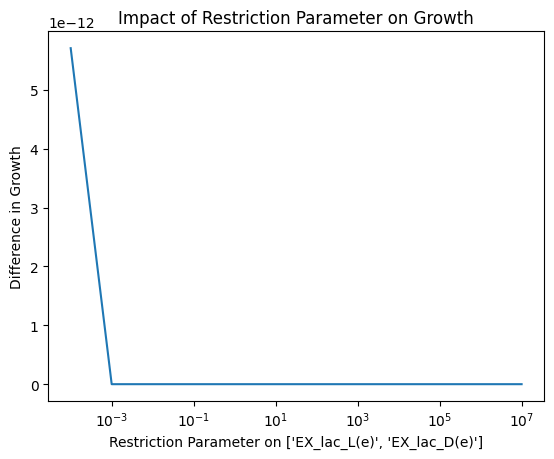

In [215]:
plot_metabolite_sensitivity(p_aeruginosa_pao1, dfu_med,
                            p_aeruginosa_pao1.reactions.bio1, report_difference= True,
                            restr_effect=[10**x for x in range(-4, 8)], enforce_changes=True)
print([10**x for x in range(-4, 8)])

In [216]:
import os
cobra.io.save_json_model(p_aeruginosa_pao1, PATH + '/' + 'p_aeruginosa_pao1.json')
os.rename(models_dictionary['p_aeruginosa_pao1'], models_dictionary['p_aeruginosa_pao1'].replace('.xml', '_Unmod.xml')) # Renaming the previous model to preserve it
cobra.io.write_sbml_model(p_aeruginosa_pao1, models_dictionary['p_aeruginosa_pao1']) # Saving the modified model with the same name

### *Bacteroides fragilis* NCTC 9343

*B. fragilis* is an obligate anaerobe commonly found in the deeper, more hypoxic regions of the wound tissue. In order to associate the presence of oxygen with a growth cost, I have used the `create_met_demand` function previously utilized for L-lactate and D-lactate.

In [217]:
# Loading the essential libraries
import cobra
import pandas as pd

In [220]:
# Loading the model for B. fragilis
b_fragilis_nctc_9343 = cobra.io.read_sbml_model(models_dictionary['b_fragilis_nctc_9343'])
b_fragilis_nctc_9343.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
2obut[e],EX_2obut(e),1000,4,26.32%
7a_czp[e],EX_7a_czp(e),281.8,15,27.82%
adn[e],EX_adn(e),0.7257,10,0.05%
amylopect900[e],EX_amylopect900(e),0.5298,5400,18.83%
amylose300[e],EX_amylose300(e),0.5047,1800,5.98%
ca2[e],EX_ca2(e),0.1451,0,0.00%
cit[e],EX_cit(e),0.2903,6,0.01%
cl[e],EX_cl(e),0.1451,0,0.00%
cobalt2[e],EX_cobalt2(e),0.1451,0,0.00%
core4[e],EX_core4(e),19.4,24,3.06%


[2.2526425169644426e-13, 4.3021142204224816e-14, 3.26405569239796e-14, 1.0269562977782698e-14, 3.086420008457935e-14, 4.742317649686356e-13, -4.0245584642661925e-14, -1.3322676295501878e-14, -4.9404924595819466e-15, 6.161737786669619e-15, 2.1038726316646716e-14, -1.1024514634527804e-13]
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]


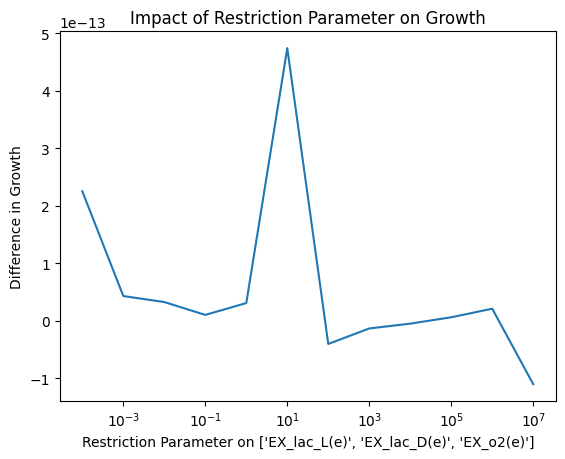

In [223]:
plot_metabolite_sensitivity(b_fragilis_nctc_9343, cobra.medium.minimal_medium(b_fragilis_nctc_9343, 0.3), # For this model, using the minimal medium yields better results
                            b_fragilis_nctc_9343.reactions.biomass345, target_met=['lac_L(c)', 'lac_D(c)', 'o2(c)'], target_exchanges=['EX_lac_L(e)', 'EX_lac_D(e)', 'EX_o2(e)'], report_difference= True,
                            restr_effect=[10**x for x in range(-4, 8)], enforce_changes=True)
print([10**x for x in range(-4, 8)])

In [224]:
import os
cobra.io.save_json_model(b_fragilis_nctc_9343, PATH + '/' + 'b_fragilis_nctc9343.json')
os.rename(models_dictionary['b_fragilis_nctc_9343'], models_dictionary['b_fragilis_nctc_9343'].replace('.xml', '_Unmod.xml')) # Renaming the previous model to preserve it
cobra.io.write_sbml_model(b_fragilis_nctc_9343, models_dictionary['b_fragilis_nctc_9343']) # Saving the modified model with the same name

### SHELVED

In [ ]:
# Comparing the 2022 build with the 2012 build (L. brevis ATCC 367)
old_l_brevis_atcc_367 = cobra.io.read_sbml_model('../reconst_2012/Lactobacillus_brevis_ATCC_367.xml')
solution = old_l_brevis_atcc_367.optimize()
old_l_brevis_atcc_367.summary(solution)

In [ ]:
import xml.parsers

def fetch_kinetic_data_from_sabio(model, organism : str, reactions = list(), update = True):
    """
    Searches for entries on each given reaction (all reactions by default) and retrieves the kinetic parameters if available.
    Updates the reactions in a model if its associated parameter is set to True.

    ## Parameters
    **model**
    The model for which the query is performed.

    **organism**
    The organism that is represented by the model.

    **reactions**
    (default `None`) The list of reactions that are to be checked and potentially updated.

    **update**
    Determines whether to update the constraints of reactions or to only print out the results of the search.

    ## References
    Most of the body of this function is derived from the *Example Python Scripts* of the **SABIO-RK** database. For more information, visit:
    https://sabiork.h-its.org/layouts/content/docuRESTfulWeb/searchPython.gsp
    """
    import requests

    QUERY = 'https://sabiork.h-its.org/sabioRestWebServices/kineticlawsExportTsv'

    if len(reactions) < 1:
        reactions = model.reactions

    for reaction in reactions:
        # Defining terms if the associated data are available.
        
        # Specifying search fields and search terms
        query_dict = {"Organism": f'"{organism}"', "ECNumber": f'"{reaction}"'}
        query_string = ' AND '.join(['%s:%s' % (k,v) for k,v in query_dict.items()])


        # Specifying output fields and send request
        # query = {'fields[]':['EntryID', 'Organism', 'UniprotID','ECNumber', 'Parameter'], 'q':query_string}

        request = requests.post(QUERY, params = query)
        request.raise_for_status()


    # Printing results
    print(request.text)


In [ ]:
import cometspy as c

def update_kinetic_param(model : cobra.Model, sabio_file : str | cobra.Model) -> c.model:
    """
    Updates the kinetic parameters in a COMETSpy model using a sabio_file containing reaction kinetic data.

    ## Parameters
    **model**
    The COBRApy model (`cobra.Model` object) whose Vmax and Km are to be updated in its respective COMETSpy model.

    **sabio_file**
    The address of or an COBRApy object of an SBML fetched from SABIO-RK.

    *Output*
    A *c.model* object.
    """
    # Converting the sabio_file parameter if necessary
    if (type(sabio_file) == str):
        sabio_file = cobra.io.read_sbml_model(sabio_file)
    # Opening the sabio_file and searching for each of the reactions in the model
    sabio_file.summary()

